In [31]:
import math
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [32]:
# use mac gpu if available
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [33]:
# convert the input number to a list of 64 bits.
# this is the input to the model

def int_to_64bit_list(number):
    binary_str = format(number, '064b')
    return [int(bit) for bit in binary_str]

In [34]:
# sin
function = lambda x: math.sin(x)

# the input ints
ints = [x for x in range(1, 100_000)]

# the input data and output labels
input_data = [int_to_64bit_list(x) for x in ints]
output_labels = [function(x) for x in ints]

In [35]:
# this is just a helper class to load the data into the model
class Data(Dataset):
    def __init__(self, inputs, outputs):
        self.inputs = inputs
        self.labels = outputs

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.inputs[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.float32)

In [36]:
# this is the machine learning model
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        # these are the layers. they are just linear transformations in the format (in, out) 
        self.layer1 = nn.Linear(64, 64 * 5) # 64 bits in
        self.layer2 = nn.Linear(64 * 5, 64 * 10)  
        self.output = nn.Linear(64 * 10, 1) # 1 value out

    # this is the forward pass. it takes the input and returns the output
    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = self.output(x)
        return x

In [37]:
# create the dataset and the loader
training_dataset = Data(input_data, output_labels)
training_loader = DataLoader(training_dataset, batch_size=32, shuffle=True)

# create model and send it to the device, the mac gpu.
model = Model().to(device)

# mean squared error loss and the optimizer
loss = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9) # learning rate and momentum are hyperparameters that can be tuned

# train the model for 50 iterations
for epoch in range(50):

    # iterate over the data
    for data in training_loader:
        inputs, labels = data

        # the labels are in the format (batch_size) but we need (batch_size, 1)
        labels = labels.view(-1, 1)

        # zero the gradients
        optimizer.zero_grad()

        # run the data through the model, we need to send it to the device as well
        out = model(inputs.to(device))
        loss_size = loss(out, labels.to(device))
        loss_size.backward() # backpropagation
        optimizer.step() # update the weights

    print(f"Loss: {loss_size}")
    
    # save the model
    torch.save(model.state_dict(), f"model-{epoch}")

Loss: 0.39404022693634033
Loss: 0.479214072227478
Loss: 0.33465245366096497
Loss: 0.48335325717926025
Loss: 0.6197061538696289
Loss: 0.5255230069160461
Loss: 0.44356805086135864
Loss: 0.1481636017560959
Loss: 0.13700668513774872
Loss: 0.04432441294193268
Loss: 0.030651701614260674
Loss: 0.013804546557366848
Loss: 0.010940640233457088
Loss: 0.004596534185111523
Loss: 0.005275445058941841
Loss: 0.014414115808904171
Loss: 0.009610923938453197
Loss: 0.010609717108309269
Loss: 0.0044547743164002895
Loss: 0.0032708225771784782
Loss: 0.00665073050186038
Loss: 0.004973029717803001
Loss: 0.0022023224737495184
Loss: 0.008438866585493088
Loss: 0.0027544493786990643
Loss: 0.0028368060011416674
Loss: 0.0041921744123101234
Loss: 0.004089124966412783
Loss: 0.010607719421386719
Loss: 0.0019470799015834928
Loss: 0.00228862464427948
Loss: 0.0018867042381316423
Loss: 0.001727276830933988
Loss: 0.003517762292176485
Loss: 0.003330545499920845
Loss: 0.001040951581671834
Loss: 0.001937993336468935
Loss: 0.00

/var/folders/42/sx5nf5k12qs453xv_z7qx_nw0000gn/T/ipykernel_57901/475498219.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(f"model-{m}")


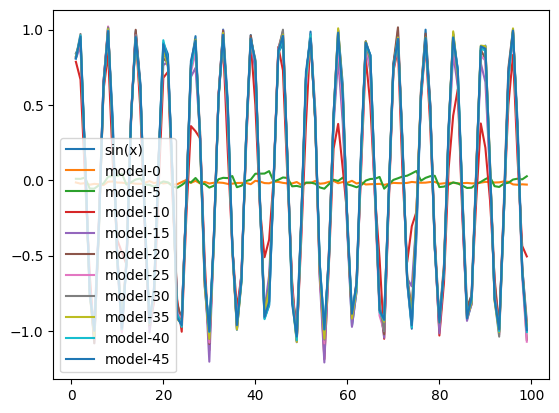

In [38]:
import matplotlib.pyplot as plt

for m in range(0, 50, 5):
  checkpoint = torch.load(f"model-{m}")
  model = Model().to(device)
  model.load_state_dict(checkpoint)

  x = [x for x in range(1, 100)]
  y = [function(x) for x in x]

  y2 = []
  for i in range(1, 100):
      val = torch.tensor(int_to_64bit_list(i), dtype=torch.float32).to(device)
      outputs = model(val)
      y2.append(outputs.data.item())

  if m == 0:
    # how to clean this plot up so it is smoother
    plt.plot(x, y, label="sin(x)")

  plt.plot(x, y2, label=f"model-{m}")

  plt.legend()

  plt.savefig(f"plot.png")

In [39]:
# def percentage_difference(a, b):
#     return abs(a - b) / ((a + b) / 2) * 100#

# checkpoint = torch.load("model")
# model = Model().to(device)
# model.load_state_dict(checkpoint)

# for i in range(20):
#   with torch.no_grad():
#     val = torch.tensor(input_data[i], dtype=torch.float32).to(device)
#     answer = torch.tensor(output_labels[i], dtype=torch.float32).to(device)

#     outputs = model(val)  # Get predictions from the model.
#     print(f"approx: {outputs.data.item()}")
#     print(f"answer: {answer}")

#     print(f"percentage difference: {percentage_difference(outputs.data.item(), answer)}%")

In [40]:
# plot both the function and the model approximation with matplotlib
# import matplotlib.pyplot as plt


# x = [x for x in range(1, 100)]
# y = [function(x) for x in x]

# y2 = []
# for i in range(1, 100):
#     val = torch.tensor(int_to_64bit_list(i), dtype=torch.float32).to(device)
#     outputs = model(val)
#     y2.append(outputs.data.item())

# # how to clean this plot up so it is smoother
# plt.plot(x, y, label="sin(x)")
# plt.plot(x, y2, label="model")

# plt.legend()

# plt.show()
